In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
# from sklearn.externals.joblib import dump, load

import pickle

from numpy.random import seed
import time

import json
import os
import shutil

import random as rn
import pickle


np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

import ray
from ray.tune.integration.keras import TuneReporterCallback
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

# from scipy.stats import norm
from scipy import stats
import sys
sys.path.append("python-fit/")
# import fit

from vae_utility import*
from config import *

In [2]:
signal_sys_d_name = os.listdir(numpy_sig_syst_down)
signal_sys_u_name = os.listdir(numpy_sig_syst_up)
signal_sys_d_name == signal_sys_u_name

True

In [3]:
cols_sel = [ 'met', 'mt', 'mct2']
cols = ['met', 'mt', 'mbb', 'mct2',
        'mlb1', 'lep1Pt', 'nJet30','nBJet30_MV2c10', 'weight']

start_c = 0
end_c = 3

In [4]:
start_c = 0
end_c = 3

temp = []
temp_name = []

signals_d_dict = {}
signal_names_d = []
nominal_signal_names = []

for sig_fold in signal_sys_d_name:
    
    dir = numpy_sig_syst_down + '{}/'.format(sig_fold)
    signal_sys_d_name_branches = os.listdir(dir)
    temp = []
    temp_name= []
    sig_mbb_d=[]
    
    for i, name in enumerate(signal_sys_d_name_branches):
        
        sig_load = np.load(dir + name)
        sig_df = pd.DataFrame(sig_load, columns=cols)
        temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)
        sig_mbb_d.append(sig_df['mbb'].values)
        
        if 'p0' in name:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p0')[0:]).split('.')[0]
        else:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p5')[0:]).split('.')[0]
            
        temp_name.append(sys_name)  

    nominal_sig_name = 'Wh_hbb_'+sig_fold+'_0.npy'

    if 'p0' in nominal_sig_name:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p0')[0:2])
    else:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p5')[0:2])
            
    temp_name.append(nominal_name) 
    sig_load = np.load(numpy_sig + nominal_sig_name)
    
    sig_df = pd.DataFrame(sig_load, columns=cols)
    temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)

    signals_d_dict[nominal_name] = temp
    
    signal_names_d.append(temp_name)
    
#     # Only the nominal name
    nominal_signal_names.append(temp_name[-1])
#     print(temp_name[-1])
    
#     if nominal_name == sig_inj:
#         sig_injected_df = sig_df

In [5]:
temp = []
temp_name = []
sig_df_mbb_u=[]
signals_u_dict = {}
signal_names_u = []
nominal_signal_names = []


for sig_fold in signal_sys_u_name:
#     print(sig_fold)
    
    dir =  numpy_sig_syst_up + '{}/'.format(sig_fold)
    signal_sys_u_name_branches = os.listdir(dir)
    temp = []
    temp_name= []
    sig_mbb_u=[]
    
    for i, name in enumerate(signal_sys_u_name_branches):

        sig_load = np.load(dir + name)
        sig_df = pd.DataFrame(sig_load, columns=cols)
        
        temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)
        sig_mbb_u.append(sig_df['mbb'].values)
        
        if 'p0' in name:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p0')[0:]).split('.')[0]
        else:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p5')[0:]).split('.')[0]
            
        temp_name.append(sys_name)               
        
    nominal_sig_name = 'Wh_hbb_'+sig_fold+'_0.npy'

    if 'p0' in nominal_sig_name:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p0')[0:2])
    else:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p5')[0:2])
            
    temp_name.append(nominal_name) 
    
    sig_load = np.load(numpy_sig + nominal_sig_name)
    sig_df = pd.DataFrame(sig_load, columns=cols)
    
    temp.append((sig_df[cols_sel[start_c:end_c] + ['weight']]).values)

    signals_u_dict[nominal_name] = temp
#     signals_mbb_u_dict[nominal_name] = sig_mbb_u
    
    signal_names_u.append(temp_name)
#     #Only the nominal
    nominal_signal_names.append(temp_name[-1])
    
#     if nominal_name == sig_inj:
#         sig_injected_df = sig_df

In [6]:
weight_KL_loss = 0.6

In [7]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss



In [8]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)


class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

In [9]:
from keras.models import load_model
custom_objects = {
#     'original_dim': 3,
#     'latent_dim': latent_dim,
#     'intermediate_dim': intermediate_dim,
#     'act_fun': act_fun,
#     'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,

#     'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

In [10]:
# signal_point = os.listdir('results_bck_sig/atlas/')[:-1]

# names = ['187_12','212_37','250_75','275_50','300_100','400_200','500_100',
#  '550_300','550_50','600_50', '650_300','700_50','750_250','800_400','900_50']

# name=names[10]

weight_KL_loss = 0.6

path = 'model_results/model_dependent/multiple_train/650_300/0_1_3_ft_3/w_5_10_10/vae_0.h5'

sig_inj = path.split('/')[3]
print(sig_inj)

check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model {}'.format(check_vae))
elif 'autoencoder' in check_vae:
    print(' \x1b[31m pay attention, you are loading autoencoder e not vae \x1b[0m')

with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
    components_dict = pickle.load(handle)
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for uputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights
print(components_dict)
# print('latent dim', latent_dim)

650_300
you are loading a vae model vae_0.h5
{'met': 5, 'mt': 10, 'mct2': 10}


In [11]:
infer_component = True #This is automatic inference when all weights in components dicts are == 0
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    elif not infer_component:
        selected_components =['met', 'mt', 'mct2']
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        print('no automatic inference, custom component loss definition {}'.format(selected_components)) 
    
else: #if w are all != 0 we need to input our selection
    
    print('no zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    else:    
        selected_components = ['met', 'mt', 'mct2']
        print('no zeros in the weights, custom loss component definitions {}'.format(selected_components)) 
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]


Nf_lognorm=0
Nf_PDgauss=0
for selected in selected_components:
    if selected in cols[:-3]:
        Nf_lognorm += 1
    else:
        Nf_PDgauss += 1
    
print('lognorm {} and pdgauss {}'.format(Nf_lognorm, Nf_PDgauss))

no zeros in the weights
automatic loss component inference ['met', 'mt', 'mct2']
lognorm 3 and pdgauss 0


In [12]:
vae = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: vae_0.h5 trained on non-zero loss: ['met', 'mt', 'mct2']  

 total loss weights [5, 10, 10] and individual loss weight: [5, 10, 10]  

selected output indexes [2, 3, 4] (shifetd by two beacuse of model output) for the component sum that is: ['met', 'mt', 'mct2']


In [13]:
if path.split('/')[1] != 'model_dependent':
    
    model_dependent = False
    
    back = np.load(train_val_test + 'background.npy')
    train = np.load(train_val_test + 'background_train.npy')
    val = np.load(train_val_test + 'background_val.npy')

    try:
        test = np.load(train_val_test + 'background_test.npy')
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test, tacking val')
        val = np.load(train_val_test + 'background_val.npy')
        sample = 'background_val.npy'

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    print('model independent test, val reweighting {}, {}'.format(split_test, split_val))

    
elif path.split('/')[1] == 'model_dependent':
    
    model_dependent = True
    name_sig = sig_inj

    back = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_{}.npy'\
                   .format(name_sig, name_sig))
    train = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_train_{}.npy'\
                    .format(name_sig, name_sig))
    val = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    val_bkg_only = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_val_{}.npy'\
                  .format(name_sig, name_sig))
    try:
        test = np.load(train_val_test_mod_dep + 'bkg_sig_{}_30_30_40/background_sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test')

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    split_val_bkg_only = 1/(np.sum(val_bkg_only[:,-1])/(np.sum(back[:,-1])))
    
    print('model dependent on {}'.format(sig_inj))

model dependent on 650_300


In [14]:
start_c = 0
end_c = 3

reg = 'signal'
regs = ['all', 'signal', 'reg_1', 'reg_2', 'reg_3', 'exstensive']
ranges_mbb = [[100,350], [100, 140], [0,75], [75,150], [150,300], [100,600]]

range_mbb = ranges_mbb[regs.index(reg)]
range_mct2 = [100,1000]

val_factor = split_val
val_df = pd.DataFrame(val, columns=cols)
sample_v = val_df[cols_sel[start_c:end_c] + ['weight']].values

out_bkg_v = vae.predict(sample_v[:,:-1], batch_size=2000)
loss_bkg_v = np.column_stack((weight_KL_loss*out_bkg_v[0]+out_bkg_v[1], 
                                  out_bkg_v[1], out_bkg_v[0])).T

test_df = pd.DataFrame(test, columns=cols)
sample_t = test_df[cols_sel[start_c:end_c] + ['weight']].values

out_bkg_t = vae.predict(sample_t[:,:-1], batch_size=2000)
loss_bkg_t = np.column_stack((weight_KL_loss*out_bkg_t[0]+out_bkg_t[1], 
                                  out_bkg_t[1], out_bkg_t[0])).T


sig_factor = 1
print('sig factor: {}'.format(sig_factor))  

sig factor: 1


In [16]:
dataset_name = 'test'

if dataset_name == 'validation':
    dataset = sample_v
    reweight = split_val
elif dataset_name == 'test':
    dataset = sample_t
    reweight = split_test

In [103]:
n1=500
n2=70
n3=30
N = [n1,n2,n3]

bins = 1
factor = 1

value_all = [1]

Ns_d_dict ={}
Ns_all_v  = {}

num_loss = 1
N_exp = 5

total_s_d = []
selected_bck_d = []
min_t = -50
maxi_t = 1000

for idx_sig, sig_name in enumerate(nominal_signal_names):
    print(sig_name)

    if int(sig_name.split('_')[0])<= 300:
        n=N[0]
    elif (int(sig_name.split('_')[0])> 300) & (int(sig_name.split('_')[0])<= 600):
        n=N[1]
    else:
        n=N[2]
    
    temp_matrix = np.zeros((N_exp, len(value_all),len(signals_d_dict[sig_name])))
    total_s_temp = []
    selected_bck_temp = []
    maxi_t = 2000
    for row in range(N_exp):
        out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
        for i, sel in enumerate(selected_idx):
            if i == 0:
                all_components_bkg = out_bkg[sel]
                all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
            else:
                all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                                , (len(out_bkg[sel]),1))), axis = 1)

        loss_back_t=np.sum(all_components_bkg, axis=1)
        
        ####HISTO RANGE FOR VAL_LOSS DISTRIBUTION####
        histo_range = (min_t,maxi_t)
        bins_back = int(maxi_t-min_t)*20000
        counts_dval, edges_dval = np.histogram((loss_back_t).astype(float),
                                               range=histo_range, bins =bins_back,
                                               weights=dataset[:,-1]*reweight) 
        loss_sig = []
        #In top we fixed the Nominal signals, here we loop on the systematics
        #and nominal distribution
        for sig_id, sig in enumerate(signals_d_dict[sig_name]):          
            out_sig = vae.predict(sig[:,:-1], batch_size=2000)
            for i, sel in enumerate(selected_idx):
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))
            loss_sig.append(np.sum(all_components_sig_temp, axis = 1))
            
        #We predicted on Validation and the signals:
        #No we can retrieve all the threshold for the fixe Number ov events to select   
        th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)]+
                    edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1])/2              
        histo_range_test = (th, maxi_t)
        counts_d, edges_d = np.histogram((loss_back_t).astype(float),
                                               range=histo_range_test, bins =bins,
                                               weights=dataset[:,-1]*reweight) 
        print('counts_d {}'.format(counts_d))
        
        #Top we fixed the Nominal signals, here we loop
        #on the systematics and nominal distribution
        for i in range(len(signals_d_dict[sig_name])):
            #For each signal we iterate on all the weight factor:
            #here only the nominal case
            for col, v in enumerate(value_all):
                counts_s, edges_s = np.histogram((loss_sig[i]).astype(float),
                                                 range=histo_range_test, 
                                bins =bins, weights = signals_d_dict[sig_name][i][:,-1]*v)
                #Collect all the signals events, so fix the minimum threshold
                print('counts_d {} counts_s {}'.format(counts_d, counts_s))
                temp_matrix[row,col,i]=(counts_s)    
            #the last signal in the list is the nominal, so count all the nominal events
        histo_range_min = (min_t, maxi_t)
        counts_s_tot, edges_s_tot = np.histogram((loss_sig[i]).astype(float),
                                         range=histo_range_min, 
                                           bins =bins, weights = signals_d_dict[sig_name][i][:,-1]*v)
        total_s_temp.append(counts_s_tot)
        selected_bck_temp.append(counts_d)
        
    total_s_d.append(np.mean(total_s_temp))
    selected_bck_d.append(np.mean(selected_bck_temp))

    # At the end of the N_exp for each signals we compact our 2-d image
    # starting to fix the signals, so the plane in the temp_matrix cube to extract
    for k in range(len(signals_d_dict[sig_name])):
        temp_mean = []
        temp_std = []
        Ns_all_v = {}
        #Now loop on the factor and take the vector of the means and stds fo each on of that
        for l in range(len(value_all)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
            temp_std.append(np.std(temp_matrix[:,l,k]))
        Ns_all_v[signal_names_d[idx_sig][k]] = temp_mean, temp_std
        
        #Put the vector so obtained in the dictory
        #1-key = nominal sig and 2-key the relative signal computed (k)
        #sig_name is the nominal name, signal_names_d is the [systs+nominal] names
        try:
            Ns_d_dict[sig_name][signal_names_d[idx_sig][k]]= Ns_all_v[signal_names_d[idx_sig][k]] 
#             print(signal_names_d[idx_sig][k], Ns_all_v[signal_names_d[idx_sig][k]] )
        except: 
            Ns_d_dict[sig_name] = Ns_all_v
            
            d = np.abs(counts_d+temp_mean[0] - counts_d)           
            sigma = np.sqrt(counts_d)
            tt = d/(sigma)
            pv = 1- stats.norm.cdf(tt)
            print(Ns_all_v, 'proxy p-value {}'.format(pv))

1000_0
counts_d [29.99793173]
counts_d [29.99793173] counts_s [2.40641472]
counts_d [29.99793173] counts_s [2.40641472]
counts_d [29.99793173] counts_s [2.41250452]
counts_d [29.99793173] counts_s [2.41981812]
counts_d [29.99793173] counts_s [2.42794816]
counts_d [29.99793173] counts_s [2.41250452]
counts_d [29.99793173] counts_s [2.41267666]
counts_d [29.99793173] counts_s [2.39246992]
counts_d [29.99793173] counts_s [2.40422065]
counts_d [29.99793173] counts_s [2.40144658]
counts_d [29.99793173] counts_s [2.40059504]
counts_d [29.99793173] counts_s [2.42074789]
counts_d [29.99793173] counts_s [2.42407278]
counts_d [29.99793173] counts_s [2.4043794]
counts_d [29.99793173] counts_s [2.39829675]
counts_d [29.99793173] counts_s [2.41466525]
counts_d [29.99793173] counts_s [2.41466525]
counts_d [29.99793173] counts_s [2.40433889]
counts_d [29.99793173] counts_s [2.42615063]
counts_d [29.99793173] counts_s [2.41250452]
counts_d [29.99793173] counts_s [2.41981812]
counts_d [29.99793173] cou

In [104]:
# n1=500
# n2=70
# n3=30
N = [n1,n2,n3]

Ns_u_dict ={}
Ns_all_v  = {}


total_s_u = []
selected_bck_u = []

for idx_sig, sig_name in enumerate(nominal_signal_names):
    print(sig_name)

    if int(sig_name.split('_')[0])<= 300:
        n=N[0]
    elif (int(sig_name.split('_')[0])> 300) & (int(sig_name.split('_')[0])<= 600):
        n=N[1]
    else:
        n=N[2]
    
    temp_matrix = np.zeros((N_exp, len(value_all),len(signals_u_dict[sig_name])))
    total_s_temp = []
    selected_bck_temp = []
    maxi_t = 2000
    for row in range(N_exp):
        out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
        for i, sel in enumerate(selected_idx):
            if i == 0:
                all_components_bkg = out_bkg[sel]
                all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
            else:
                all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                                , (len(out_bkg[sel]),1))), axis = 1)

        loss_back_t=np.sum(all_components_bkg, axis=1)
        
        ####HISTO RANGE FOR VAL_LOSS DISTRIBUTION####
        histo_range = (min_t,maxi_t)
        bins_back = int(maxi_t-min_t)*20000
        counts_dval, edges_dval = np.histogram((loss_back_t).astype(float),
                                               range=histo_range, bins =bins_back,
                                               weights=dataset[:,-1]*reweight) 
        loss_sig = []
        #In top we fixed the Nominal signals, here we loop on the systematics
        #and nominal distribution
        for sig_id, sig in enumerate(signals_u_dict[sig_name]):          
            out_sig = vae.predict(sig[:,:-1], batch_size=2000)
            for i, sel in enumerate(selected_idx):
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))
            loss_sig.append(np.sum(all_components_sig_temp, axis = 1))
            
        #We predicted on Validation and the signals:
        #No we can retrieve all the threshold for the fixe Number of events to select   
        th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)]+
                    edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1])/2              
        histo_range_test = (th, maxi_t)
        counts_d, edges_d = np.histogram((loss_back_t).astype(float),
                                               range=histo_range_test, bins =bins,
                                               weights=dataset[:,-1]*reweight) 
        print('counts_d {}'.format(counts_d))
        
        #Top we fixed the Nominal signals, here we loop
        #on the systematics and nominal distribution
        for i in range(len(signals_u_dict[sig_name])):
            #For each signal we iterate on all the weight factor:
            #here only the nominal case
            for col, v in enumerate(value_all):
                counts_s, edges_s = np.histogram((loss_sig[i]).astype(float),
                                                 range=histo_range_test, 
                                bins =bins, weights = signals_u_dict[sig_name][i][:,-1]*v)
                #Collect all the signals events, so fix the minimum threshold
                print('counts_d {} counts_s {}'.format(counts_d, counts_s))
                temp_matrix[row,col,i]=(counts_s)    
            #the last signal in the list is the nominal, so count all the nominal events
        histo_range_min = (min_t, maxi_t)
        counts_s_tot, edges_s_tot = np.histogram((loss_sig[i]).astype(float),
                                         range=histo_range_min, 
                                           bins =bins, weights = signals_u_dict[sig_name][i][:,-1]*v)
        total_s_temp.append(counts_s_tot)
        selected_bck_temp.append(counts_d)
        
    total_s_u.append(np.mean(total_s_temp))
    selected_bck_u.append(np.mean(selected_bck_temp))

    # At the end of the N_exp for each signals we compact our 2-d image
    # starting to fix the signals, so the plane in the temp_matrix cube to extract
    for k in range(len(signals_u_dict[sig_name])):
        temp_mean = []
        temp_std = []
        Ns_all_v = {}
        #Now loop on the factor and take the vector of the means and stds fo each on of that
        for l in range(len(value_all)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
            temp_std.append(np.std(temp_matrix[:,l,k]))
        Ns_all_v[signal_names_d[idx_sig][k]] = temp_mean, temp_std
        
        #Put the vector so obtained in the dictory
        #1-key = nominal sig and 2-key the relative signal computed (k)
        #sig_name is the nominal name, signal_names_d is the [systs+nominal] names
        try:
            Ns_u_dict[sig_name][signal_names_d[idx_sig][k]]= Ns_all_v[signal_names_d[idx_sig][k]] 
#             print(signal_names_d[idx_sig][k], Ns_all_v[signal_names_d[idx_sig][k]] )
        except: 
            Ns_u_dict[sig_name] = Ns_all_v
            d = np.abs(counts_d+temp_mean[0] - counts_d)           
            sigma = np.sqrt(counts_d)
            tt = d/(sigma)
            pv = 1- stats.norm.cdf(tt)
            print(Ns_all_v, 'proxy p-value {}'.format(pv))

1000_0
counts_d [29.94451491]
counts_d [29.94451491] counts_s [2.42086358]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.42208739]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.41272824]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.39552834]
counts_d [29.94451491] counts_s [2.42407278]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.39159875]
counts_d [29.94451491] counts_s [2.42074789]
counts_d [29.94451491] counts_s [2.41981812]
counts_d [29.94451491] counts_s [2.41010987]
counts_d [29.94451491] counts_s [2.40642188]
counts_d [29.94451491] counts_s [2.42631398]
counts_d [29.94451491] counts_s [2.42553472]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.39488645]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] counts_s [2.41250452]
counts_d [29.94451491] co

In [19]:
# Ns_u_dict=Ns_d_dict

In [21]:
# total_s_d = total_s_u
# selected_bck_d = selected_bck_u

In [137]:
# import pickle
# with open('boot_dict_results/down_boot_{}_30_exp_{}_{}_{}_{}_feat.pickle'.format(name, n1,n2,n3,3), 'rb') as handle:
#     Ns_d_dict = pickle.load(handle)

N0_tot = [(x+y)/2 for x,y in zip(total_s_d,total_s_u)] 
selected_bck = [(x+y)/2 for x,y in zip(selected_bck_d,selected_bck_u)] 

In [138]:
save = True
load = True

In [139]:
if save :

    Ns_d_dict['N0'] = N0_tot
    Ns_d_dict['selected_bck'] = selected_bck

    with open('dict_results/down_{}_{}_exp_{}_{}_{}_{}_feat.pickle'\
              .format(sig_inj, N_exp, n1,n2,n3,val.shape[1]-1)
              , 'wb') as handle:
        pickle.dump(Ns_d_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('dict_results/up_{}_{}_exp_{}_{}_{}_{}_feat.pickle'\
              .format(sig_inj,N_exp, n1,n2,n3,val.shape[1]-1)
              , 'wb') as handle:
        pickle.dump(Ns_u_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [140]:
if load:
    path = 'dict_results/down_650_300_30_exp_500_70_30_8_feat.pickle'

    with open(path, 'rb') as handle:
        Ns_d_dict = pickle.load(handle)
    with open(path.split('/')[0] + '/up_' + '_'.join(path.split('/')[1].split('_')[1:]), 'rb') as handle:
        Ns_u_dict = pickle.load(handle)
        
    N0_tot = Ns_d_dict['N0']
    selected_bck = Ns_d_dict['selected_bck']

    del Ns_d_dict['selected_bck']
    del Ns_d_dict['N0']
    
    N_exp = int(path.split('/')[1].split('_exp')[0].split('_')[-1])
    
    n1=int(path.split('/')[1].split('exp_')[1].split('_')[0])
    n2=int(path.split('/')[1].split('exp_')[1].split('_')[1])
    n3=int(path.split('/')[1].split('exp_')[1].split('_')[2])
    
    N = [n1,n2,n3]

## Way 2

In [143]:
delta_d = []
for i, name in enumerate(nominal_signal_names):

    N0d = Ns_d_dict[name][name][0][0]
    N0u = Ns_u_dict[name][name][0][0]
    N0_unc_d = Ns_d_dict[name][name][1][0]
    N0_unc_u = Ns_u_dict[name][name][1][0]

    N0 = (N0d+N0u)/2
    N0_unc = (N0_unc_d+N0_unc_u)/2
    
    delta_eff_history = []
    delta_yield_squared_history = []
    delta_yield_unc_squared_history = []
    
    for k, v in Ns_d_dict[name].items():
        
        delta_yield_squared = (np.abs(N0-v[0]))**2 
        delta_yield_squared_history.append(delta_yield_squared)
            
    delta_d.append([N0, np.sqrt(sum(delta_yield_squared_history)), N0_unc])

In [144]:
delta_u = []
for i, name in enumerate(nominal_signal_names):
    N0d = Ns_d_dict[name][name][0][0]
    N0u = Ns_u_dict[name][name][0][0]
    N0_unc_d = Ns_d_dict[name][name][1][0]
    N0_unc_u = Ns_u_dict[name][name][1][0]
    
    N0 = (N0d+N0u)/2
    N0_unc = (N0_unc_d+N0_unc_u)/2
#     eff0 = N0/N0_tot[i]
    
    delta_eff_history = []
    delta_yield_squared_history = []
    delta_yield_unc_squared_history = []
    for k, v in Ns_u_dict[name].items():
        
        delta_yield_squared = (np.abs(N0-v[0]))**2 
        delta_yield_squared_history.append(delta_yield_squared)
        
    delta_u.append([N0, np.sqrt(sum(delta_yield_squared_history)), N0_unc])

In [145]:
syst_error = []
fluctuactions = []
N_0 = []

for i, name in enumerate(nominal_signal_names):
    
    N0l = delta_d[i][0]
    N0u = delta_u[i][0]
    N0 = (N0l+N0u)/2
    
    N_0.append(N0)
    syst_error.append((delta_d[i][1] + delta_u[i][1])) 
    fluctuactions.append(delta_d[i][2])

In [146]:
relative_flu_distr = [x/y for x,y in zip(fluctuactions,N_0)]

In [147]:
relative_sys_distr = [x/y for x,y in zip(syst_error,N_0)]

In [148]:
nominal_signal_for_sorting = [int(x.split('_')[0]) for x in nominal_signal_names]
index = np.argsort(nominal_signal_for_sorting)
nominal_signal_names_sorted = [nominal_signal_names[x] for x in index]
relative_sys_distr_sorted = [relative_sys_distr[x] for x in index]

In [149]:
relative_sys_distr_sorted = [relative_sys_distr_sorted[:30],
                                           relative_sys_distr_sorted[30:60],
                                           relative_sys_distr_sorted[60:90],
                                        relative_sys_distr_sorted[90:]]

In [158]:
# SYstematics fast method
bins_back=2000
bins = 1
factor = 1
value_all = [1]

p_v_dict_both ={}
p_value_all_v_both = {}

s_temp = []
weights = []

temp_matrix = np.zeros((1, len(value_all),len(nominal_signal_names)))

for idx_sig, sig_name in enumerate(nominal_signal_names):
    
    counts_d_mean = selected_bck[idx_sig]
    s_mean = delta_d[idx_sig][0] - delta_d[idx_sig][1] + delta_u[idx_sig][1]
    d = np.abs((counts_d_mean+s_mean) - counts_d_mean)

    index = np.argmax([delta_d[idx_sig][1],delta_u[idx_sig][1]])
    sys_err_0 = [delta_d[idx_sig][1],delta_u[idx_sig][1]][index]

    sigma = np.sqrt((sys_err_0*2)**2 + np.sqrt(counts_d_mean)**2 + fluctuactions[i]**2)
#     sigma = np.sqrt((sys_err_0*2)**2 + (np.sqrt(counts_d_mean)/np.sqrt(N_exp))**2 
#                         + fluctuactions[i]**2)

    tt = d/(sigma)

    temp_matrix[0,0,idx_sig]=tt    
    ######################T-test#########################################################################                       
    for k in range(len(nominal_signal_names)):
        temp_mean = []
        temp_std = []
        p_value_all_v_both = {}

        for l in range(len(value_all)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
            temp_std.append(np.std(temp_matrix[:,l,k]))
        p_v_dict_both[nominal_signal_names[k]] = temp_mean, temp_std

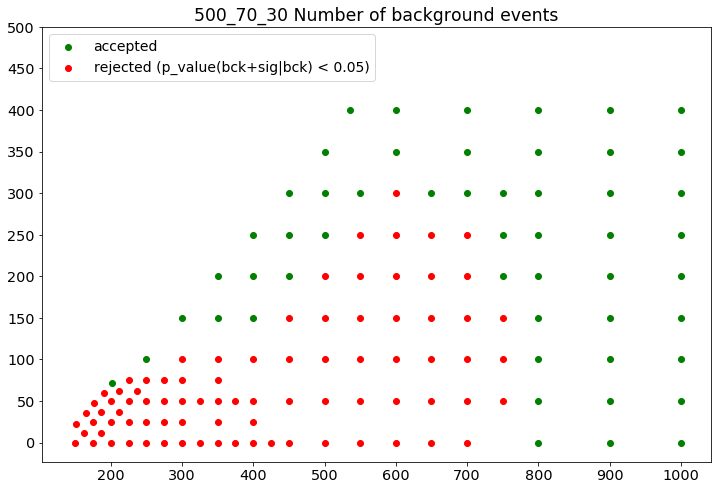

In [160]:
f, ax_arr = plt.subplots(1,1 , figsize=(12,8))
accepted_name = []
rejected_name = []

x_acc_n=[]
y_acc_n=[]
x_rej_n=[]
y_rej_n=[]

for k, value in enumerate(p_v_dict_both.items()):

    tt = value[1][0][0]
#     sigma = p_v_dict[sig_name][1][0]
    
    pv = 1- stats.norm.cdf(tt)

    if (pv > 0.05):

        x_acc_n.append(int(value[0].split('_')[0]))
        y_acc_n.append(int(value[0].split('_')[1]))
            
    else:
        x_rej_n.append(int(value[0].split('_')[0]))
        y_rej_n.append(int(value[0].split('_')[1]))

ax_arr.scatter(x_acc_n, y_acc_n, color = 'green',
                                  label = 'accepted')      
ax_arr.scatter(x_rej_n, y_rej_n, color = 'red', label = 'rejected (p_value(bck+sig|bck) < 0.05)')    
ax_arr.set_title('{}_{}_{} Number of background events'.format(N[0],N[1],N[2])
                    , size='xx-large')
ax_arr.set_xticks([200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
ax_arr.tick_params(labelsize='x-large')  

ax_arr.legend(fontsize = 14, loc='upper left')

# plt.savefig('results/update_2/exclusion_region/exclusion_region_syst_{}_{}_{}_total_syst_sig_400_200_mod_17.pdf'.format(N[0],N[1],N[2]))

In [163]:
# SYstematics fast method
bins_back=2000
bins = 1
factor = 1
value_all = [1]

p_v_dict_l ={}
p_value_all_v_l = {}

s_temp = []
weights = []

temp_matrix = np.zeros((1, len(value_all),len(nominal_signal_names)))

for idx_sig, sig_name in enumerate(nominal_signal_names):
    
    counts_d_mean = selected_bck[idx_sig]
    s_mean = delta_d[idx_sig][0] - delta_d[idx_sig][1]

    d = np.abs((counts_d_mean+s_mean) - counts_d_mean)

    index = np.argmax([delta_d[idx_sig][1],delta_u[idx_sig][1]])
    sys_err_0 = [delta_d[idx_sig][1],delta_u[idx_sig][1]][index]

    sigma = np.sqrt((sys_err_0*2)**2 + np.sqrt(counts_d_mean)**2)
#     sigma = np.sqrt((sys_err_0*2)**2 + np.sqrt(counts_d_mean)**2 + fluctuactions[i]**2)
    tt = d/(sigma)
    temp_matrix[0,0,idx_sig]=tt
    
    ######################T-test#########################################################################                       
    for k in range(len(nominal_signal_names)):
        temp_mean = []
        temp_std = []
        p_value_all_v_l = {}
        for l in range(len(value_all)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
            temp_std.append(np.std(temp_matrix[:,l,k]))
        p_v_dict_l[nominal_signal_names[k]] = temp_mean, temp_std

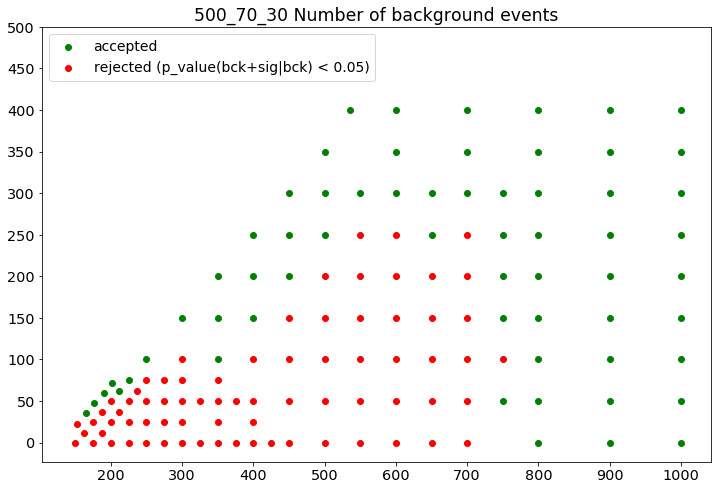

In [164]:
f, ax_arr = plt.subplots(1,1 , figsize=(12,8))
# accepted_name_l = []
# rejected_name_l = []

x_acc_l=[]
y_acc_l=[]
x_rej_l=[]
y_rej_l=[]

for k, value in enumerate(p_v_dict_l.items()):

    tt = value[1][0][0]
    
    pv = 1- stats.norm.cdf(tt)


    if (pv >= 0.05):

        x_acc_l.append(int(value[0].split('_')[0]))
        y_acc_l.append(int(value[0].split('_')[1]))

              
    else:
        x_rej_l.append(int(value[0].split('_')[0]))
        y_rej_l.append(int(value[0].split('_')[1]))


ax_arr.scatter(x_acc_l, y_acc_l, color = 'green',
                                  label = 'accepted')      
ax_arr.scatter(x_rej_l, y_rej_l, color = 'red', label = 'rejected (p_value(bck+sig|bck) < 0.05)')    
ax_arr.set_title('{}_{}_{} Number of background events'.format(N[0],N[1],N[2])
                    , size='xx-large')
ax_arr.set_xticks([200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
ax_arr.tick_params(labelsize='x-large')  

ax_arr.legend(fontsize = 14, loc='upper left')

# plt.savefig('results/exclusion_region_low_syst_{}_{}_{}_all_error.pdf'.format(N[0],N[1],N[2]))

In [166]:
# SYstematics fast method

bins = 1
factor = 1
value_all = [1]

p_v_dict_u ={}
p_value_all_v_u = {}

s_temp = []
weights = []

temp_matrix = np.zeros((1, len(value_all),len(nominal_signal_names)))

for idx_sig, sig_name in enumerate(nominal_signal_names):
        
    counts_d_mean = selected_bck[idx_sig]
    s_mean = delta_d[idx_sig][0] + delta_u[idx_sig][1]
#         print(counts_d_mean,s_mean)
    d = np.abs((counts_d_mean+s_mean) - counts_d_mean)

    index = np.argmax([delta_d[idx_sig][1],delta_u[idx_sig][1]])
    sys_err_0 = [delta_d[idx_sig][1],delta_u[idx_sig][1]][index]

    sigma = np.sqrt((sys_err_0*2)**2 + np.sqrt(counts_d_mean)**2)
#         sigma = np.sqrt((sys_err_0*2)**2 + (np.sqrt(counts_d_mean))**2 
#                         + fluctuactions[i]**2)

    tt = d/(sigma)

    temp_matrix[0,0,idx_sig]=tt
    
    ######################T-test#########################################################################
    for k in range(len(nominal_signal_names)):
        temp_mean = []
        temp_std = []
        p_value_all_v_u = {}
        for l in range(len(value_all)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
            temp_std.append(np.std(temp_matrix[:,l,k]))
        p_v_dict_u[nominal_signal_names[k]] = temp_mean, temp_std

In [217]:
# dic = []
# x_list_n = []
# y_list_n = []
# pv_list = []
# lista = []
# for k, value in enumerate(p_v_dict_u.items()):

#     tt = value[1][0][0]
#     pv_list.append(t.sf(np.abs(tt), 50-1))

#     x_list_n.append(int(value[0].split('_')[0]))
#     y_list_n.append(int(value[0].split('_')[1]))
#     dic_temp = {}
#     dic_temp = {'x':int(value[0].split('_')[0]),
#                'y':int(value[0].split('_')[1]),
#                'CLs':pv_list[-1]}
#     dic.append(dic_temp)
# with open('upper.json', 'w') as outfile:
#     json.dump(dic, outfile)

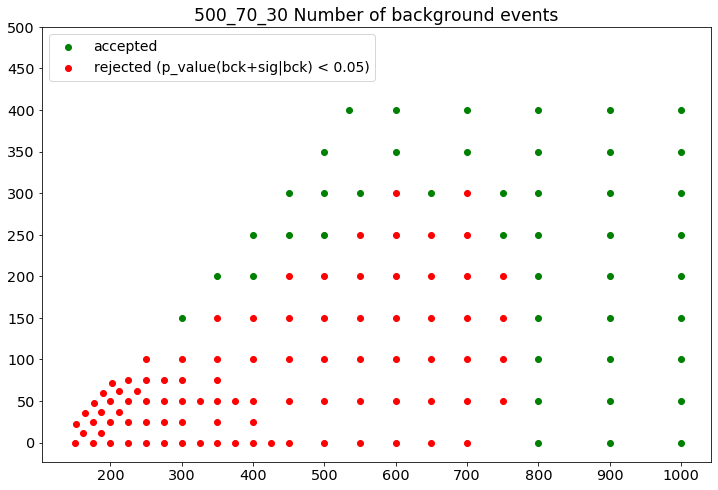

In [167]:
f, ax_arr = plt.subplots(1,1 , figsize=(12,8))

x_acc_u=[]
y_acc_u=[]
x_rej_u=[]
y_rej_u=[]

for k, value in enumerate(p_v_dict_u.items()):

    tt = value[1][0][0]   
    pv = 1- stats.norm.cdf(tt)

    if (pv >= 0.05):

        x_acc_u.append(int(value[0].split('_')[0]))
        y_acc_u.append(int(value[0].split('_')[1]))

              
    else:
        x_rej_u.append(int(value[0].split('_')[0]))
        y_rej_u.append(int(value[0].split('_')[1]))


ax_arr.scatter(x_acc_u, y_acc_u, color = 'green',
                                  label = 'accepted')      
ax_arr.scatter(x_rej_u, y_rej_u, color = 'red', label = 'rejected (p_value(bck+sig|bck) < 0.05)')    
ax_arr.set_title('{}_{}_{} Number of background events'.format(N[0],N[1],N[2])
                    , size='xx-large')
ax_arr.set_xticks([200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
ax_arr.tick_params(labelsize='x-large')  

ax_arr.legend(fontsize = 14, loc='upper left')

# plt.savefig('results/exclusion_region_syst_up_{}_{}_{}_all_error.pdf'.format(N[0],N[1],N[2]))

In [168]:
dic = []
x_list_n = []
y_list_n = []
pv_list = []
pv_list_d = []
pv_list_u = []
lista = []
for k, value in (p_v_dict_both.items()):
    
    tt = value[0][0]
    ttd = p_v_dict_l[k][0][0]
    ttu = p_v_dict_u[k][0][0]
    
    pv_list.append(1- stats.norm.cdf(tt))
    pv_list_d.append(1- stats.norm.cdf(ttd))
    pv_list_u.append(1- stats.norm.cdf(ttu))

    x_list_n.append(int(k.split('_')[0]))
    y_list_n.append(int(k.split('_')[1]))
    
    dic_temp = {}
    
    dic_temp = {'x':int(k.split('_')[0]),
               'y':int(k.split('_')[1]),
               'CLs':pv_list[-1], #Observed
               'CLsexp':pv_list[-1], #Expected
               "clsu1s":pv_list_u[-1],
                "clsu2s":pv_list_u[-1],
                
                "clsd1s":pv_list_d[-1],
                "clsd2s":pv_list_d[-1],
                
                "upperLimit":pv_list_u[-1],
                "expectedUpperLimit":pv_list_u[-1]
               }
    
    dic.append(dic_temp)

# dic['sample'] = lista
    
# dic['x']=x_list_n
# dic['y']=y_list_n
# dic['zValues']=pv_list
with open('nominal_{}_3_feats.json'.format(sig_inj), 'w') as outfile:
    json.dump(dic, outfile)

In [125]:
dic = []
x_list_n = []
y_list_n = []
pv_list = []
pv_list_d = []
pv_list_u = []
lista = []
for k, value in (p_v_dict_both.items()):
    
    tt = value[0][0]
    ttd = p_v_dict_l[k][0][0]
    ttu = p_v_dict_u[k][0][0]
    
    pv_list.append(t.sf(np.abs(tt), 50-1))
    pv_list_d.append(t.sf(np.abs(ttd), 50-1))
    pv_list_u.append(t.sf(np.abs(ttu), 50-1))

    x_list_n.append(int(k.split('_')[0]))
    y_list_n.append(int(k.split('_')[1]))
    
    if int(k.split('_')[0]) != 800:

        dic_temp = {}

        dic_temp = {'x':int(k.split('_')[0]),
                   'y':int(k.split('_')[1]),
                   'CLs':pv_list[-1], #Observed
                   'CLsexp':pv_list[-1], #Expected
                   "clsu1s":pv_list_u[-1],
                    "clsu2s":pv_list_u[-1],

                    "clsd1s":pv_list_d[-1],
                    "clsd2s":pv_list_d[-1],

                    "upperLimit":pv_list_u[-1],
                    "expectedUpperLimit":pv_list_u[-1]
                   }

        dic.append(dic_temp)

# dic['sample'] = lista
    
# dic['x']=x_list_n
# dic['y']=y_list_n
# dic['zValues']=pv_list
# with open('nominal_800less.json', 'w') as outfile:
#     json.dump(dic, outfile)

In [229]:
counting = [2204,2210,2222,2105,2301]

In [202]:
# unc = [np.sqrt(x) for x in counting]

In [231]:
unc_fin = (1/5)*np.sqrt(np.sum(counting)) #n_exp = 1

In [232]:
unc_fin

21.016184239771025

In [196]:
(2204+2210+2222+2105+2301)/5

2208.4

In [233]:
np.sqrt(2208.4)/np.sqrt(5)

21.01618423977102

In [94]:
with open('nominal_fake_2.json', 'w') as outfile:
    json.dump(dic, outfile)

In [ ]:
# dic['zValues']=pv_list
with open('nominal_fake.json', 'w') as outfile:
    json.dump(dic, outfile)

In [153]:
x_values = [int(x.split('_')[0]) for x in nominal_signal_names]
y_values = [int(x.split('_')[1]) for x in nominal_signal_names]

In [154]:
x_values = np.unique(x_values)
y_values = np.unique(y_values)

In [161]:
coord_n=[[0,0]]*len(x_rej)
for i,x in enumerate(x_values):
    for j,x_check in enumerate(x_rej_n):
        if x==x_check:
            if y_rej_n[j]>coord_n[i][1]:
                coord_n[i] = [x_values[i], y_rej_n[j]]
                
coord_n_fin = [(x[0],x[1]) for x in coord_n if (x[0]!=0)&(x[1]!=0)]     
coord_n_fin.sort()

coord_n_1tolast = (0,1000)
for j,x_check in enumerate(x_rej_n):
    if x_check==max(coord_n_fin)[0]:
        if y_rej_n[j]<coord_n_1tolast[1]:
            coord_n_1tolast = (x_check, y_rej_n[j])
coord_n_fin.append(coord_n_1tolast)

coord_n_last = (0,0)
for i,x in enumerate(x_values):
    for j,x_check in enumerate(x_rej_n):
        if x==x_check:
            if (y_rej_n[j]==0) & (x_check>coord_n_last[0]):
                coord_n_last = (x_check, y_rej_n[j])
coord_n_fin.append(coord_n_last)

x_n = [i[0] for i in coord_n_fin]
y_n = [i[1] for i in coord_n_fin[:-2]]
y_n.append(coord_n_fin[-2][1])
y_n.append(coord_n_fin[-1][1])

# index = x_l.index([325])
# del(x_l[index])
# del(y_l[index])
# index = x_l.index([375])
# del(x_l[index])
# del(y_l[index])

In [162]:
coord_l=[[0,0]]*len(x_rej)
for i,x in enumerate(x_values):
    for j,x_check in enumerate(x_rej_l):
        if x==x_check:
            if y_rej_l[j]>coord_l[i][1]:
                coord_l[i] = [x_values[i], y_rej_l[j]]
                
coord_l_fin = [(x[0],x[1]) for x in coord_l if (x[0]!=0)&(x[1]!=0)]     
coord_l_fin.sort()

coord_l_1tolast = (0,1000)
for j,x_check in enumerate(x_rej_l):
    if x_check==max(coord_l_fin)[0]:
        if y_rej_l[j]<coord_l_1tolast[1]:
            coord_l_1tolast = (x_check, y_rej_l[j])
coord_l_fin.append(coord_l_1tolast)

coord_l_last = (0,0)
for i,x in enumerate(x_values):
    for j,x_check in enumerate(x_rej_l):
        if x==x_check:
            if (y_rej_l[j]==0) & (x_check>coord_l_last[0]):
                coord_l_last = (x_check, y_rej_l[j])
coord_l_fin.append(coord_l_last)

x_l = [i[0] for i in coord_l_fin]
y_l = [i[1] for i in coord_l_fin[:-2]]
y_l.append(coord_l_fin[-2][1])
y_l.append(coord_l_fin[-1][1])

# index = x_l.index([325])
# del(x_l[index])
# del(y_l[index])
# index = x_l.index([375])
# del(x_l[index])
# del(y_l[index])

In [175]:
min(x_values)

150

In [174]:
min(x_rej_u)

150

In [184]:
coord_u=[[0,0]]*len(x_rej)
for i,x in enumerate(x_values):
    for j,x_check in enumerate(x_rej_u):
        if x==x_check:
            if y_rej_u[j]>=coord_u[i][1]:
                coord_u[i] = [x_values[i], y_rej_u[j]]
                
coord_u_fin = [(x[0],x[1]) for x in coord_u if (x[0]!=0)|(x[1]!=0)]     
coord_u_fin.sort()

coord_u_1tolast = (0,1000)
for j,x_check in enumerate(x_rej_u):
    if x_check==max(coord_u_fin)[0]:
        if y_rej_u[j]<coord_u_1tolast[1]:
            coord_u_1tolast = (x_check, y_rej_u[j])
coord_u_fin.append(coord_u_1tolast)

coord_u_last = (0,0)
for i,x in enumerate(x_values):
    for j,x_check in enumerate(x_rej_u):
        if x==x_check:
            if (y_rej_u[j]==0) & (x_check>coord_u_last[0]):
                coord_u_last = (x_check, y_rej_u[j])
coord_u_fin.append(coord_u_last)

x_u = [i[0] for i in coord_u_fin]
# y_u = [i[1] for i in coord_u_fin]
y_u = [i[1] for i in coord_u_fin[:-2]]
y_u.append(coord_u_fin[-2][1])
y_u.append(coord_u_fin[-1][1])

# index = x_u.index([325])
# del(x_u[index])
# del(y_u[index])
# index = x_u.index([375])
# del(x_u[index])
# del(y_u[index])

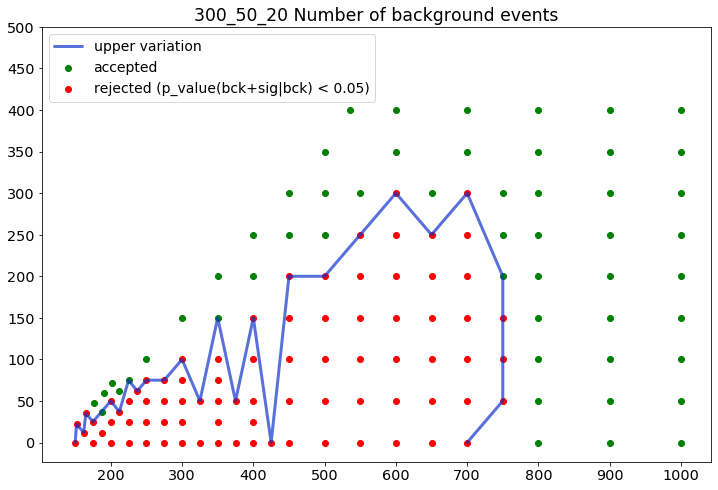

In [185]:
f, ax_arr = plt.subplots(1,1 , figsize=(12,8))

ax_arr.scatter(x_acc_n, y_acc_n, color = 'green',
                                  label = 'accepted')      
ax_arr.scatter(x_rej_n, y_rej_n, color = 'red', label = 'rejected (p_value(bck+sig|bck) < 0.05)')   

# ax_arr.plot(x_l, y_l, color='#6699cc', alpha=0.7,
#     linewidth=3, solid_capstyle='round', zorder=2, label = 'lower variation')

ax_arr.plot(x_u, y_u, color='#1234cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2, label = 'upper variation')

# ax_arr.plot(x_n, y_n, color='#5678cc', alpha=0.7,
#     linewidth=3, solid_capstyle='round', zorder=2, label = 'upper variation')

ax_arr.set_title('{}_{}_{} Number of background events'.format(N[0],N[1],N[2])
                    , size='xx-large')
ax_arr.set_xticks([200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
ax_arr.tick_params(labelsize='x-large')  

ax_arr.legend(fontsize = 14, loc='upper left')

# plt.savefig('results/exclusion_region_syst_both_{}_{}_{}_all_error.pdf'.format(N[0],N[1],N[2]))

In [580]:
import math

In [633]:
exp =100
obs =118

In [634]:
1-sum([((exp**x)/math.factorial(x))*np.exp(-exp)
       for x in range(obs)])

0.04284487248662183

In [635]:
1-(scipy.stats.poisson.cdf(obs-1,exp))

0.04284487248662183

In [636]:
d = np.abs(exp-(obs-0.8))

sig = np.sqrt(exp)

t = d/sig

# (1-scipy.stats.norm.cdf(t))
t

1.7200000000000002

In [515]:
(1-scipy.stats.norm.cdf(t))

0.02275013194817921